### Global Imports

In [3]:
import os
import datetime

import numpy as np
import tensorflow as tf

### Get Data

In [4]:
def get_data(file_name, mode='sample', test_size=.1, seed=None):
    """Load data from NPZ file and split into train and test sets
    # Arguments
        file_name: path to NPZ file to load
        mode: if 'sample', will return datapoints for each pixel,
              otherwise, returns the same data that was loaded
        test_size: percent of data to leave as testing holdout
        seed: seed number for random train/test split repeatability
    # Returns
        dict of training data, and a tuple of testing data:
        train_dict, (X_test, y_test)
    """
    training_data = np.load(file_name)
    X = training_data['X']
    y = training_data['y']
    win_x = training_data['win_x']
    win_y = training_data['win_y']
    win_z = None

    class_weights = training_data['class_weights'] if 'class_weights' in training_data else None

    if mode == 'sample' and X.ndim == 4:
        batch = training_data['batch']
        pixels_x = training_data['pixels_x']
        pixels_y = training_data['pixels_y']

        if CHANNELS_FIRST:
            sample_shape = (len(batch), X.shape[1], 2 * win_x + 1, 2 * win_y + 1)
        else:
            sample_shape = (len(batch), 2 * win_x + 1, 2 * win_y + 1, X.shape[3])
        X_sample = np.zeros(sample_shape, dtype=K.floatx())

        for i, (b, px, py) in enumerate(zip(batch, pixels_x, pixels_y)):
            if CHANNELS_FIRST:
                X_sample[i] = X[b, :, px - win_x:px + win_x + 1, py - win_y:py + win_y + 1]
            else:
                X_sample[i] = X[b, px - win_x:px + win_x + 1, py - win_y:py + win_y + 1, :]

        X = X_sample


    # siamese_data mode creates additional channels for tracking data (centroid x, centroid y, etc)
    if mode == 'siamese_data':
        batch_length = X.shape[0]

        if CHANNELS_FIRST:
            X_new = np.zeros((X.shape[0], X.shape[1]+2, X.shape[2], X.shape[3], X.shape[4]))
            x_centroid_weight_dist = np.zeros(X.shape[3], X.shape[4])
            y_centroid_weight_dist = np.zeros(X.shape[3], X.shape[4])
            num_frames = X.shape[2]
        else:
            X_new = np.zeros((X.shape[0], X.shape[1], X.shape[2], X.shape[3], X.shape[4]+2))
            x_centroid_weight_dist = np.zeros((X.shape[2], X.shape[3]))
            y_centroid_weight_dist = np.zeros((X.shape[2], X.shape[3]))
            num_frames = X.shape[1]

        for b in range(batch_length):
            for f in range(num_frames):
                if CHANNELS_FIRST:
                    X_new[b,1,f,:,:] = X[b,0,f,:,:]
                    X_new[b,1,f,:,:], X_new[b,2,f,:,:] = centroid_weighted_distance_transform_2d(y[b,0,f,:,:])
                else:
                    X_new[b,f,:,:,0] = X[b,f,:,:,0]
                    X_new[b,f,:,:,1], X_new[b,f,:,:,2] = centroid_weighted_distance_transform_2d(y[b,f,:,:,0])

        X = X_new
    # End changes for data mode

    elif mode == 'sample' and X.ndim == 5:
        batch = training_data['batch']
        pixels_x = training_data['pixels_x']
        pixels_y = training_data['pixels_y']
        pixels_z = training_data['pixels_z']
        win_z = training_data['win_z']

        if CHANNELS_FIRST:
            sample_shape = (len(batch), X.shape[1], 2 * win_z + 1, 2 * win_x + 1, 2 * win_y + 1)
        else:
            sample_shape = (len(batch), 2 * win_z + 1, 2 * win_x + 1, 2 * win_y + 1, X.shape[4])
        X_sample = np.zeros(sample_shape, dtype=K.floatx())

        for i, (b, px, py, pz) in enumerate(zip(batch, pixels_x, pixels_y, pixels_z)):
            if CHANNELS_FIRST:
                X_sample[i] = X[b, :, pz - win_z:pz + win_z + 1, px - win_x:px + win_x + 1, py - win_y:py + win_y + 1]
            else:
                X_sample[i] = X[b, pz - win_z:pz + win_z + 1, px - win_x:px + win_x + 1, py - win_y:py + win_y + 1, :]

        X = X_sample

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=seed)

    train_dict = {
        'X': X_train,
        'y': y_train,
        'class_weights': class_weights,
        'win_x': win_x,
        'win_y': win_y
    }

    # siamese_daughters mode is used to import lineage data and associate it with the appropriate batch
    if mode == 'siamese_daughters':
        kid_data = np.load(os.path.splitext(file_name)[0]+'_kids.npz')
        daughters = kid_data['daughters']
        X_train, X_test, y_train, y_test, lineage_train, lineage_test = train_test_split(X, y, daughters, test_size=test_size, random_state=seed)
        train_dict = {
            'X': X_train,
            'y': y_train,
            'daughters': lineage_train,
            'class_weights': class_weights,
            'win_x': win_x,
            'win_y': win_y
        }
        y_test = [y_test, lineage_test]
    # End changes for daughter mode

    if win_z is not None:
        train_dict['win_z'] = win_z


    return train_dict, (X_test, y_test)

### Data Generators

In [14]:
from tensorflow.python.keras.preprocessing.image import Iterator
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

from tensorflow.python.keras import backend as K
from sklearn.model_selection import train_test_split

from skimage.measure import label
from skimage.measure import regionprops
from skimage.transform import resize

class SiameseDataGenerator(ImageDataGenerator):
    def flow(self,
             train_dict,
             crop_dim=32,
             min_track_length=5,
             batch_size=32,
             shuffle=True,
             seed=None,
             data_format=None,
             save_to_dir=None,
             save_prefix='',
             save_format='png'):
        return SiameseIterator(
            train_dict,
            self,
            crop_dim=crop_dim,
            min_track_length=min_track_length,
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            data_format=data_format,
            save_to_dir=save_to_dir,
            save_prefix=save_prefix,
            save_format=save_format)


class SiameseIterator(Iterator):
    def __init__(self,
                 train_dict,
                 image_data_generator,
                 crop_dim=14,
                 min_track_length=5,
                 batch_size=32,
                 shuffle=False,
                 seed=None,
                 data_format=None,
                 save_to_dir=None,
                 save_prefix='',
                 save_format='png'):
        if data_format is None:
            data_format = K.image_data_format()

        if data_format == 'channels_first':
            self.channel_axis = 1
            self.row_axis = 3
            self.col_axis = 4
            self.time_axis = 2
        if data_format == 'channels_last':
            self.channel_axis = 4
            self.row_axis = 2
            self.col_axis = 3
            self.time_axis = 1
        self.x = np.asarray(train_dict['X'], dtype=K.floatx())
        self.y = np.array(train_dict['y'], dtype='int32')

        if self.x.ndim != 5:
            raise ValueError('Input data in `SiameseIterator` '
                             'should have rank 5. You passed an array '
                             'with shape', self.x.shape)

        self.crop_dim = crop_dim
        self.min_track_length = min_track_length
        self.image_data_generator = image_data_generator
        self.data_format = data_format
        self.save_to_dir = save_to_dir
        self.save_prefix = save_prefix
        self.save_format = save_format

        if 'daughters' in train_dict:
            self.daughters = train_dict['daughters']
        else:
            self.daughters = None

        self.track_ids = self._get_track_ids()

        super(SiameseIterator, self).__init__(
            len(self.track_ids), batch_size, shuffle, seed)

    def _get_track_ids(self):
        """
        This function builds the track id's. It returns a dictionary that
        contains the batch number and label number of each each track.
        Creates unique cell IDs, as cell labels are NOT unique across batches.
        """
        track_counter = 0
        track_ids = {}
        for batch in range(self.y.shape[0]):
            y_batch = self.y[batch]
            num_cells = np.amax(y_batch)
            for cell in range(1, num_cells + 1):
                # count number of pixels cell occupies in each frame
                y_true = np.sum(y_batch == cell, axis=(self.row_axis - 1, self.col_axis - 1))
                # get indices of frames where cell is present
                y_index = np.where(y_true > 0)[0]
                if y_index.size > 0:  # if cell is present at all
                    #start_frame = np.amin(y_index)
                    #stop_frame = np.amax(y_index)
                    if self.daughters is not None:
                        track_ids[track_counter] = {
                            'batch': batch,
                            'label': cell,
                            'frames': y_index,
                            'daughters': self.daughters[batch][cell]  # not [cell-1]!
                        }
                    else:
                        track_ids[track_counter] = {
                            'batch': batch,
                            'label': cell,
                            'frames': y_index,
                            'daughters': []
                        }
                    track_counter += 1
        return track_ids

    def _get_batches_of_transformed_samples(self, index_array):
        # initialize batch_x_1, batch_x_2, and batch_y, as well as centroid data
        if self.data_format == 'channels_first':
            img_shape = (len(index_array), self.x.shape[self.channel_axis], self.crop_dim, self.crop_dim)
        else:
            img_shape = (len(index_array), self.crop_dim, self.crop_dim, self.x.shape[self.channel_axis])

        data_shape = (len(index_array), 2,)

        batch_x_1 = np.zeros(img_shape, dtype=K.floatx())
        batch_x_2 = np.zeros(img_shape, dtype=K.floatx())
        centroid_1 = np.zeros(data_shape, dtype=K.floatx())
        centroid_2 = np.zeros(data_shape, dtype=K.floatx())
        batch_y = np.zeros((len(index_array), 3), dtype=np.int32)

        for i, j in enumerate(index_array):
            # Identify which tracks are going to be selected
            track_id = self.track_ids[j]
            batch = track_id['batch']
            label_1 = track_id['label']
            tracked_frames = track_id['frames']
            frame_1 = np.random.choice(tracked_frames)  # Select a frame from the track

            X = self.x[batch]
            y = self.y[batch]

            # Choose comparison cell
            # Determine what class the track will be - different (0), same (1), division (2)
            # is_same_cell = np.random.random_integers(0, 1)
            type_cell = np.random.randint(0, 3)

            # There may be instances where training images only have one cell
            # In this case, we won't be able to find a diff cell to compare to
            # So we begin by compiling a list of valid cell labels (ie: all
            # cell labels except the first chosen label)
            all_labels = np.delete(np.unique(y), 0)  # all labels in y but 0 (background)
            acceptable_labels = np.delete(all_labels, np.where(all_labels == label_1))

            # If there is only 1 cell in every frame, we can only choose the class to be same
            if len(acceptable_labels) == 0:
                type_cell = 1

            # If class is division, check if the first cell divides
            # If not, change class to same/dif randomly
            if type_cell == 2:
                daughters = track_id['daughters']
                if len(daughters) == 0:
                    type_cell = np.random.random_integers(0, 1)  # No children so randomly choose a diff class
                else:
                    frame_1 = np.amax(tracked_frames)  # Get the last frame of the parent
                    frame_2 = frame_1 + 1
                    # There should always be 2 daughters but not always a valid label
                    label_2 = int(daughters[np.random.random_integers(0, len(daughters)-1)])

            # If class is same, select another frame from the same track
            if type_cell == 1:
                label_2 = label_1
                # The second frame should not be equal to the first (an exact comparison)
                # We need to assemble a new list of valid frames
                tracked_frames = np.delete(tracked_frames, np.where(tracked_frames == frame_1))
                # And verify the cell exists in more than one frame (otherwise cell it can't be tracked)
                if len(tracked_frames) > 0:
                    frame_2 = np.random.choice(tracked_frames)
                else:
                    # The cell only appears in one frame so it either split in frame 2 or it can't 
                    # (doesn't need to) be tracked. Either way, we need to select randomly from one of
                    # the other classes (different or daughter)
                    type_cell = np.random.randint(0, 2) * 2
                    if type_cell == 2:
                        daughters = track_id['daughters']
                        if len(daughters) == 0:
                            type_cell = 0 # No children & only appears in 1 frame, class must be different
                        else:
                            frame_1 = np.amax(tracked_frames)  # Get the last frame of the parent
                            frame_2 = frame_1 + 1
                            # There should always be 2 daughters but not always a valid label
                            label_2 = int(daughters[np.random.random_integers(0, len(daughters)-1)])
                    # A failure mode could be that we assumed that the class must be same because there's only
                    #  one label present but now we're enforcing class = different (which is a contradiction. 
                    if type_cell == 0 and len(acceptable_labels) == 0:
                        raise ValueError('Invalid input data. There is only one labeled cell and it only '
                                         'exists in one frame. This type of data is unsuitable for tracking'
                                         'Batch #{} and Label {}'.format(batch, label_1))

            # If class is different, select another frame from a different track
            if type_cell == 0:
                   
                is_valid_label = False
                while not is_valid_label:
                    # get a random cell label from our acceptable list
                    label_2 = np.random.choice(acceptable_labels)

                    # count number of pixels cell occupies in each frame
                    y_true = np.sum(y == label_2, axis=(
                        self.row_axis - 1, self.col_axis - 1, self.channel_axis - 1))

                    y_index = np.where(y_true > 0)[0]  # get frames where cell is present
                    is_valid_label = y_index.any()  # label_2 is in a frame
                    if not is_valid_label:
                        # remove invalid label from list of acceptable labels
                        acceptable_labels = np.delete(
                            acceptable_labels, np.where(acceptable_labels == label_2))

                frame_2 = np.random.choice(y_index)  # get random frame with label_2

            # Get appearances and centroid data
            frames = [frame_1, frame_2]
            labels = [label_1, label_2]

            appearances = self._get_appearances(X, y, frames, labels)

            # Save centroids for the pair of images
            centroid_1[i] = np.array(appearances[1][0])
            centroid_2[i] = np.array(appearances[1][1])

            # Save images of the cells in the pair of images
            appearances = appearances[0]

            if self.data_format == 'channels_first':
                appearances = [appearances[:, 0], appearances[:, 1]]
            else:
                appearances = [appearances[0], appearances[1]]

            # Apply random transformations
            for k, appearance in enumerate(appearances):
                appearance = self.image_data_generator.random_transform(appearance)
                appearance = self.image_data_generator.standardize(appearance)
                appearances[k] = appearance

            batch_x_1[i] = appearances[0]
            batch_x_2[i] = appearances[1]
            batch_y[i, type_cell] = 1

        return [batch_x_1, batch_x_2, centroid_1, centroid_2], batch_y

    def _get_appearances(self, X, y, frames, labels):
        channel_axis = self.channel_axis - 1
        if self.data_format == 'channels_first':
            appearance_shape = (X.shape[channel_axis],
                                len(frames),
                                self.crop_dim,
                                self.crop_dim)
        else:
            appearance_shape = (len(frames),
                                self.crop_dim,
                                self.crop_dim,
                                X.shape[channel_axis])

        # Initialize storage for appearances and centroids
        appearances = np.zeros(appearance_shape, dtype=K.floatx())
        centroids = []

        for counter, (frame, cell_label) in enumerate(zip(frames, labels)):
            # Get the bounding box
            y_frame = y[frame] if self.data_format == 'channels_last' else y[:, frame]
            props = regionprops(np.int32(y_frame == cell_label))
            minr, minc, maxr, maxc = props[0].bbox
            centroids.append(props[0].centroid)

            # Extract images from bounding boxes
            if self.data_format == 'channels_first':
                appearance = X[:, frame, minr:maxr, minc:maxc]
                resize_shape = (X.shape[channel_axis], self.crop_dim, self.crop_dim)
            else:
                appearance = X[frame, minr:maxr, minc:maxc, :]
                resize_shape = (self.crop_dim, self.crop_dim, X.shape[channel_axis])

            # Resize images from bounding box
            max_value = np.amax([np.amax(appearance), np.absolute(np.amin(appearance))])
            appearance /= max_value
            appearance = resize(appearance, resize_shape)
            appearance *= max_value
            if self.data_format == 'channels_first':
                appearances[:, counter] = appearance
            else:
                appearances[counter] = appearance

        return [appearances, centroids]

    def next(self):
        """For python 2.x.
        # Returns the next batch.
        """
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch.
        with self.lock:
            index_array = next(self.index_generator)
        # The transformation of images is not under thread lock
        # so it can be done in parallel
        return self._get_batches_of_transformed_samples(index_array)

### Testing the Data Generator

In [15]:
data = np.load('/data/npz_data/cells/HeLa/S3/movie/nuclear_movie_hela0_same.npz')

train_dict, (X_test, y_test) = get_data('/data/npz_data/cells/HeLa/S3/movie/nuclear_movie_hela0_same.npz',
                                        mode='siamese_daughters')

print('X_train shape:', train_dict['X'].shape)

image_data_generator = SiameseDataGenerator(
        rotation_range=0,  # randomly rotate images by 0 to rotation_range degrees
        shear_range=0, # randomly shear images in the range (radians , -shear_range to shear_range)
        horizontal_flip=0,  # randomly flip images
        vertical_flip=0) 

test_iterator = SiameseIterator(train_dict, image_data_generator, crop_dim=32)

X_train shape: (22, 40, 216, 256, 1)


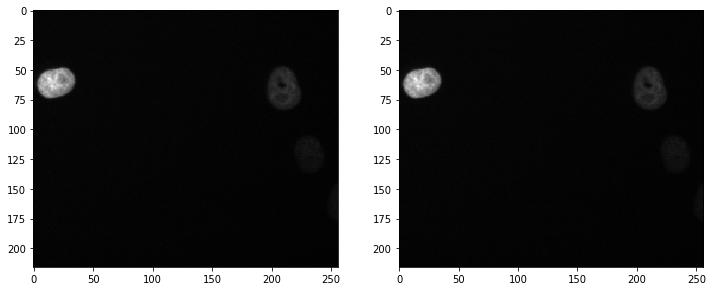

In [16]:
import matplotlib.pyplot as plt
from skimage.io import imshow

# Compare 2 images
img_1 = train_dict['X'][0,1,:,:,0]
img_2 = train_dict['X'][0,1,:,:,0]

fig, ax = plt.subplots(1, 2, figsize=(12,12))
ax[0].imshow(img_1, interpolation='none', cmap='gray')
ax[1].imshow(img_2, interpolation='none', cmap='gray')
plt.show()

In [47]:
(lst, y) = test_iterator.next()

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:172: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead


In [48]:
print(lst[0].shape)
print(lst[1].shape)
print(lst[2].shape)
print(lst[3].shape)

(32, 32, 32, 1)
(32, 32, 32, 1)
(32, 2)
(32, 2)


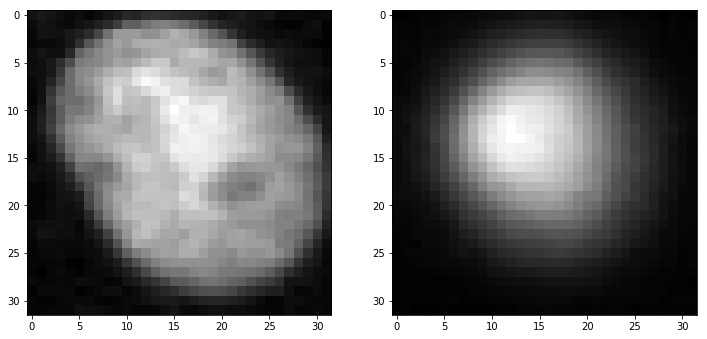

In [56]:
img_1 = lst[0][3,:,:,0]
img_2 = lst[1][3,:,:,0]

fig, ax = plt.subplots(1, 2, figsize=(12,12))
ax[0].imshow(img_1, interpolation='none', cmap='gray')
ax[1].imshow(img_2, interpolation='none', cmap='gray')
plt.show()

In [57]:
# Print Centroid Data
print(lst[2][3,:])
print(lst[3][3,:])

[143.54106   34.534622]
[164.76399  88.46294]


In [51]:
# Check the labels
print(y)

[[0 1 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]]


### Model Zoo

In [ ]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import tensorflow as tf
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.activations import softmax
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Conv2D, Conv3D, ConvLSTM2D
from tensorflow.python.keras.layers import Add, Input, Concatenate, Lambda
from tensorflow.python.keras.layers import MaxPool2D, MaxPool3D, AvgPool2D, UpSampling2D
from tensorflow.python.keras.layers import Flatten, Dense, Dropout
from tensorflow.python.keras.layers import Activation, Softmax
from tensorflow.python.keras.layers import BatchNormalization
from tensorflow.python.keras.regularizers import l2

from .layers import Resize
from .layers import DilatedMaxPool2D, DilatedMaxPool3D
from .layers import TensorProd2D, TensorProd3D
from .layers import Location, Location3D
from .layers import ImageNormalization2D, ImageNormalization3D

def siamese_model(input_shape=None, batch_shape=None, reg=1e-5, init='he_normal', softmax=True, norm_method='std', filter_size=61):

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    # Define the input shape for the images
    input_1 = Input(shape=input_shape)
    input_2 = Input(shape=input_shape)
    # Define the input shape for the other data (centroids, etc)
    input_3 = Input(shape=(2, ))
    input_4 = Input(shape=(2, ))

    # Sequential interface for siamese portion of model
    feature_extractor = Sequential()
    feature_extractor.add(Conv2D(64, (3, 3), kernel_initializer=init, padding='same', kernel_regularizer=l2(reg), input_shape=input_shape))
    feature_extractor.add(BatchNormalization(axis=channel_axis))
    feature_extractor.add(Activation('relu'))
    feature_extractor.add(Conv2D(64, (3, 3), kernel_initializer=init, padding='same', kernel_regularizer=l2(reg)))
    feature_extractor.add(BatchNormalization(axis=channel_axis))
    feature_extractor.add(Activation('relu'))
    feature_extractor.add(MaxPool2D(pool_size=(2, 2)))
    feature_extractor.add(Conv2D(64, (3, 3), kernel_initializer=init, padding='same', kernel_regularizer=l2(reg)))
    feature_extractor.add(BatchNormalization(axis=channel_axis))
    feature_extractor.add(Activation('relu'))
    feature_extractor.add(Conv2D(64, (3, 3), kernel_initializer=init, padding='same', kernel_regularizer=l2(reg)))
    feature_extractor.add(BatchNormalization(axis=channel_axis))
    feature_extractor.add(Activation('relu'))
    feature_extractor.add(MaxPool2D(pool_size=(2, 2)))

    # Create two instances of feature_extractor
    output_1 = feature_extractor(input_1)
    output_2 = feature_extractor(input_2)

    # Combine the extracted features with other known features (centroids)
    flat1 = Flatten()(output_1)
    flat2 = Flatten()(output_2)
    merge_1 = Concatenate()([flat1, input_3])
    merge_2 = Concatenate()([flat2, input_4])

    # Concatenate outputs from both instances
    merged_outputs = Concatenate(axis=channel_axis)([merge_1, merge_2])

    # Implement dense net (Alternatively, could call preexisting) with the 2 merged outputs as inputs
    dense1 = Dense(128)(merged_outputs)
    bn1 = BatchNormalization(axis=channel_axis)(dense1)
    relu1 = Activation('relu')(bn1)
    dense2 = Dense(128)(relu1)
    bn2 = BatchNormalization(axis=channel_axis)(dense2)
    relu2 = Activation('relu')(bn2)
    dense3 = Dense(3, activation='softmax')(relu2)

    # Instantiate model
    final_layer = dense3
    model = Model(inputs=[input_1, input_2, input_3, input_4], outputs=final_layer)

    return model

### Training the Model

In [ ]:
from skimage.external import tifffile as tiff
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils import to_categorical as keras_to_categorical
from tensorflow.python.keras.callbacks import ModelCheckpoint, LearningRateScheduler

from .image_generators import SiameseDataGenerator
from .losses import weighted_categorical_crossentropy
from .utils.io_utils import get_images_from_directory
from .utils.train_utils import rate_scheduler
from .utils.transform_utils import to_categorical
from .settings import CHANNELS_FIRST

def train_model_siamese_daughter(model=None, dataset=None, optimizer=None,
                        expt='', it=0, batch_size=1, n_epoch=100,
                        direc_save='/data/models', direc_data='/data/npz_data',
                        lr_sched=rate_scheduler(lr=0.01, decay=0.95),
                        rotation_range=0, flip=True, shear=0, class_weight=None):

    training_data_file_name = os.path.join(direc_data, dataset + '.npz')
    todays_date = datetime.datetime.now().strftime('%Y-%m-%d')

    file_name_save = os.path.join(direc_save, '{}_{}_{}_{}.h5'.format(todays_date, dataset, expt, it))
    file_name_save_loss = os.path.join(direc_save, '{}_{}_{}_{}.npz'.format(todays_date, dataset, expt, it))

    train_dict, (X_test, y_test) = get_data(training_data_file_name, mode='siamese_daughters')

    class_weights = train_dict['class_weights']
    # the data, shuffled and split between train and test sets
    print('X_train shape:', train_dict['X'].shape)
    print('y_train shape:', train_dict['y'].shape)
    print('X_test shape:', X_test.shape)
    print('y_test shape:', y_test[0].shape)
    print('Output Shape:', model.layers[-1].output_shape)

    n_classes = model.layers[-1].output_shape[1 if CHANNELS_FIRST else -1]

    def loss_function(y_true, y_pred):
        return weighted_categorical_crossentropy(y_true, y_pred,
                                                 n_classes=n_classes,
                                                 from_logits=False)

    model.compile(loss=loss_function, optimizer=optimizer, metrics=['accuracy'])

    print('Using real-time data augmentation.')

    # this will do preprocessing and realtime data augmentation
    datagen = SiameseDataGenerator(
        rotation_range=rotation_range,  # randomly rotate images by 0 to rotation_range degrees
        shear_range=shear,  # randomly shear images in the range (radians , -shear_range to shear_range)
        horizontal_flip=flip,  # randomly flip images
        vertical_flip=flip)  # randomly flip images

    datagen_val = SiameseDataGenerator(
        rotation_range=0,  # randomly rotate images by 0 to rotation_range degrees
        shear_range=0,  # randomly shear images in the range (radians , -shear_range to shear_range)
        horizontal_flip=0,  # randomly flip images
        vertical_flip=0)  # randomly flip images

    validation_dict = {'X': X_test, 'y': y_test[0], 'daughters': y_test[1]}

    def count_pairs(y):
        """
        Compute number of training samples needed to (stastically speaking)
        observe all cell pairs.
        Assume that the number of images is encoded in the second dimension.
        Assume that y values are a cell-uniquely-labeled mask.
        Assume that a cell is paired with one of its other frames 50% of the time
        and a frame from another cell 50% of the time.
        """
        # TODO: channels_first axes
        total_pairs = 0
        for image_set in range(y.shape[0]):
            set_cells = 0
            cells_per_image = []
            for image in range(y.shape[1]):
                image_cells = int(y[image_set, image, :, :, :].max())
                set_cells = set_cells + image_cells
                cells_per_image.append(image_cells)

            # Since there are many more possible non-self pairings than there are self pairings,
            # we want to estimate the number of possible non-self pairings and then multiply
            # that number by two, since the odds of getting a non-self pairing are 50%, to
            # find out how many pairs we would need to sample to (statistically speaking)
            # observe all possible cell-frame pairs.
            # We're going to assume that the average cell is present in every frame. This will
            # lead to an underestimate of the number of possible non-self pairings, but it's
            # unclear how significant the underestimate is.
            average_cells_per_frame = int(sum(cells_per_image) / len(cells_per_image))
            non_self_cellframes = (average_cells_per_frame - 1) * len(cells_per_image)
            non_self_pairings = non_self_cellframes * max(cells_per_image)
            cell_pairings = non_self_pairings * 2
            total_pairs = total_pairs + cell_pairings
        return total_pairs

    # This shouldn't remain long term.
    total_train_pairs = count_pairs(train_dict['y'])
    total_test_pairs = count_pairs(y_test[0])

    print("total_train_pairs:", total_train_pairs)
    print("total_test_pairs:", total_test_pairs)
    print("batch size: ", batch_size)
    print("validation_steps: ", total_test_pairs // batch_size)

    # fit the model on the batches generated by datagen.flow()
    loss_history = model.fit_generator(
        datagen.flow(train_dict, batch_size=batch_size),
        steps_per_epoch=total_train_pairs // batch_size,
        epochs=n_epoch,
        validation_data=datagen_val.flow(validation_dict, batch_size=batch_size),
        validation_steps=total_test_pairs // batch_size,
        callbacks=[
            ModelCheckpoint(file_name_save, monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
            LearningRateScheduler(lr_sched)
        ])

    model.save_weights(file_name_save)
    np.savez(file_name_save_loss, loss_history=loss_history.history)

    return model

In [ ]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.optimizers import SGD
from tensorflow.python.keras.models import Sequential, Model

from deepcell import rate_scheduler, siamese_model, train_model_siamese_daughter

direc_data = '/data/npz_data/cells/HeLa/S3/movie/'
dataset = 'nuclear_movie_hela0_same'

training_data = np.load('{}{}.npz'.format(direc_data, dataset))

optimizer = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
lr_sched = rate_scheduler(lr=0.001, decay=0.99)
in_shape = (32, 32, 1)
model = siamese_model(input_shape=in_shape)
for layer in model.layers:
    print(layer.name)

train_model_siamese_daughter(model=model,
                    dataset=dataset,
                    optimizer=optimizer,
                    expt='',
                    it=0,
                    batch_size=128,
                    n_epoch=10,
                    direc_save='/data/models/cells/HeLa/S3',
                    direc_data=direc_data,
                    lr_sched=lr_sched,
                    rotation_range=0,
                    flip=True,
                    shear=0,
                    class_weight=None)